<a href="https://colab.research.google.com/github/HARIGIT29/Cryptocurrency-Price-Prediction-Using-Machine-Learning/blob/main/Cryptocurrency_price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install and Import Necessary Libraries**

In [ ]:
!pip install yfinance
import yfinance as yf
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# **Fetch The Cryptocurrency Data**

In [ ]:
import yfinance as yf
import datetime

# Get today's date
today = datetime.date.today()

# Calculate yesterday's date
yesterday = today - datetime.timedelta(days=1)

# Fetch cryptocurrency data up to today's date
df = yf.download('BTC-USD', start='2012-01-01', end=yesterday)

df['DayOfWeek'] = df.index.dayofweek

# Add technical indicators (example: 20-day SMA and RSI)
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# Calculate price differences
delta = df['Close'].diff()

# Separate positive and negative changes
gain = delta.where(delta > 0, 0)  # Replace negative changes with 0
loss = -delta.where(delta < 0, 0) # Replace positive changes with 0

# Calculate average gain and loss over 14 periods
avg_gain = gain.rolling(window=14, min_periods=1).mean() #min_periods=1 to handle initial values
avg_loss = loss.rolling(window=14, min_periods=1).mean()

# Calculate Relative Strength (RS)
rs = avg_gain / avg_loss

# Calculate RSI
df['RSI'] = 100 - (100 / (1 + rs))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# **Display Data and Shape**

In [ ]:
# Show the data
print(df)

# Get the number of rows and columns in the data set
print(df.shape)

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2014-09-17    457.334015    468.174011    452.421997    465.864014   
2014-09-18    424.440002    456.859985    413.104004    456.859985   
2014-09-19    394.795990    427.834991    384.532013    424.102997   
2014-09-20    408.903992    423.295990    389.882996    394.673004   
2014-09-21    398.821014    412.425995    393.181000    408.084991   
...                  ...           ...           ...           ...   
2025-02-22  96577.757812  96950.156250  95765.343750  96134.203125   
2025-02-23  96273.921875  96671.875000  95270.453125  96577.804688   
2025-02-24  91418.171875  96503.453125  91371.742188  96277.960938   
2025-02-25  88736.171875  92511.078125  86008.234375  91437.117188   
2025-02-26  84347.023438  89286.250000  82131.898438  88638.890625   

Price            Vo

# **Visualize the Closing Price**

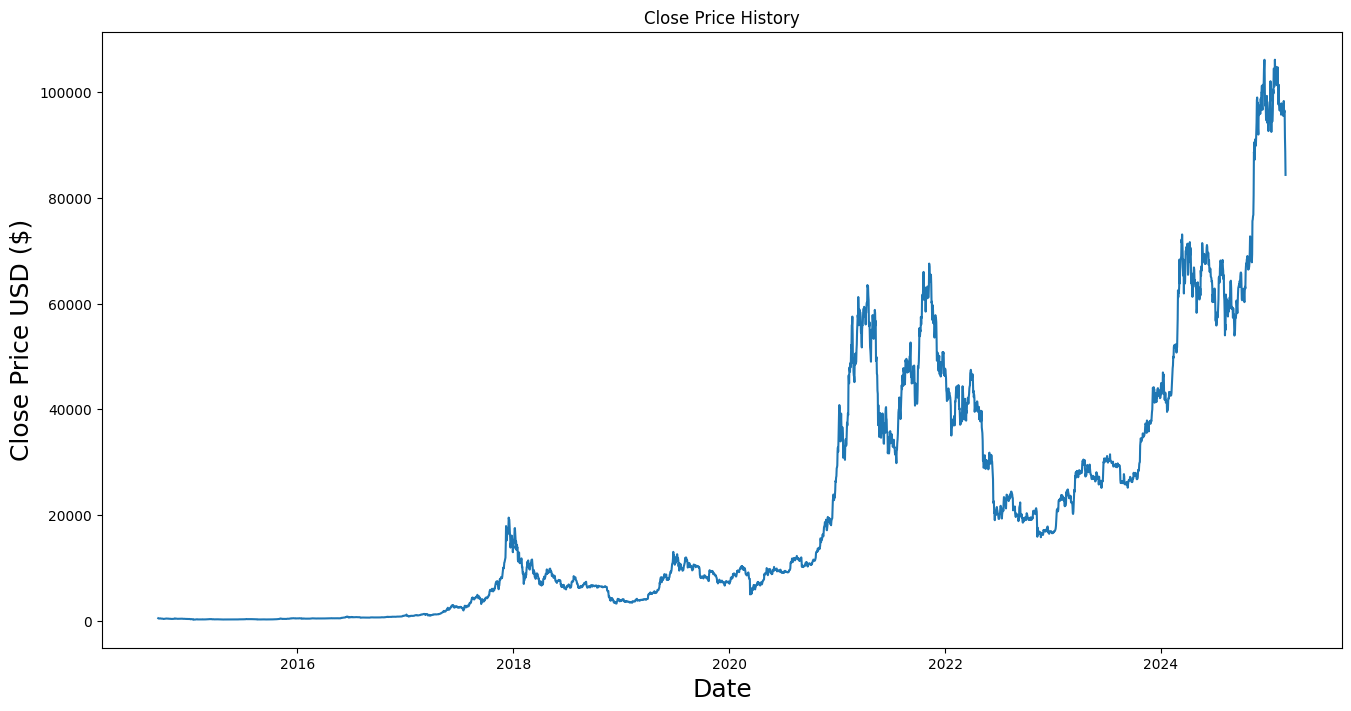

In [ ]:
# Visualize the closing price history
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# **Data Preparation**

In [ ]:
# Create a new dataframe with only the 'Close' column
# Use double brackets to select the column as a DataFrame
data = df[['Close']]

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)
print(training_data_len)

3053


# **Scale the Data**

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# **Prepare Training Data**

In [ ]:
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# **Build the LSTM Model**

In [ ]:
from keras.layers import Bidirectional
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))) # First LSTM layer
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True)) # Second LSTM layer (returns sequences for next LSTM)
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False)) # Third LSTM Layer (no need to return sequences)
model.add(Dropout(0.2))
model.add(Dense(25)) # Reduce neurons here
model.add(Dense(1))

# Compile the model (this part remains the same)
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **Train the Model**

In [ ]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - loss: 3.9876e-04 - val_loss: 8.5343e-04
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - loss: 4.5155e-04 - val_loss: 0.0044
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - loss: 6.2973e-04 - val_loss: 0.0013
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - loss: 3.9023e-04 - val_loss: 6.6575e-04
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 3.0815e-04 - val_loss: 7.0485e-04
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 3.6075e-04 - val_loss: 5.8074e-04
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 3.4846e-04 - val_loss: 8.4091e-04
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - loss: 2.8413e-04 - val_loss: 5.9470e-04
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 3.4989e-04 - val_loss: 0.0011
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - los

# **Prepare Testing Data**

In [ ]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# **Make predictions and Calculate Error**

In [ ]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


# Step 9: Calculate RMSE
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'Root Mean Squared Error (RMSE): {rmse}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
Root Mean Squared Error (RMSE): 2384.0653965978504


# **Visualize Predictions vs Actual**

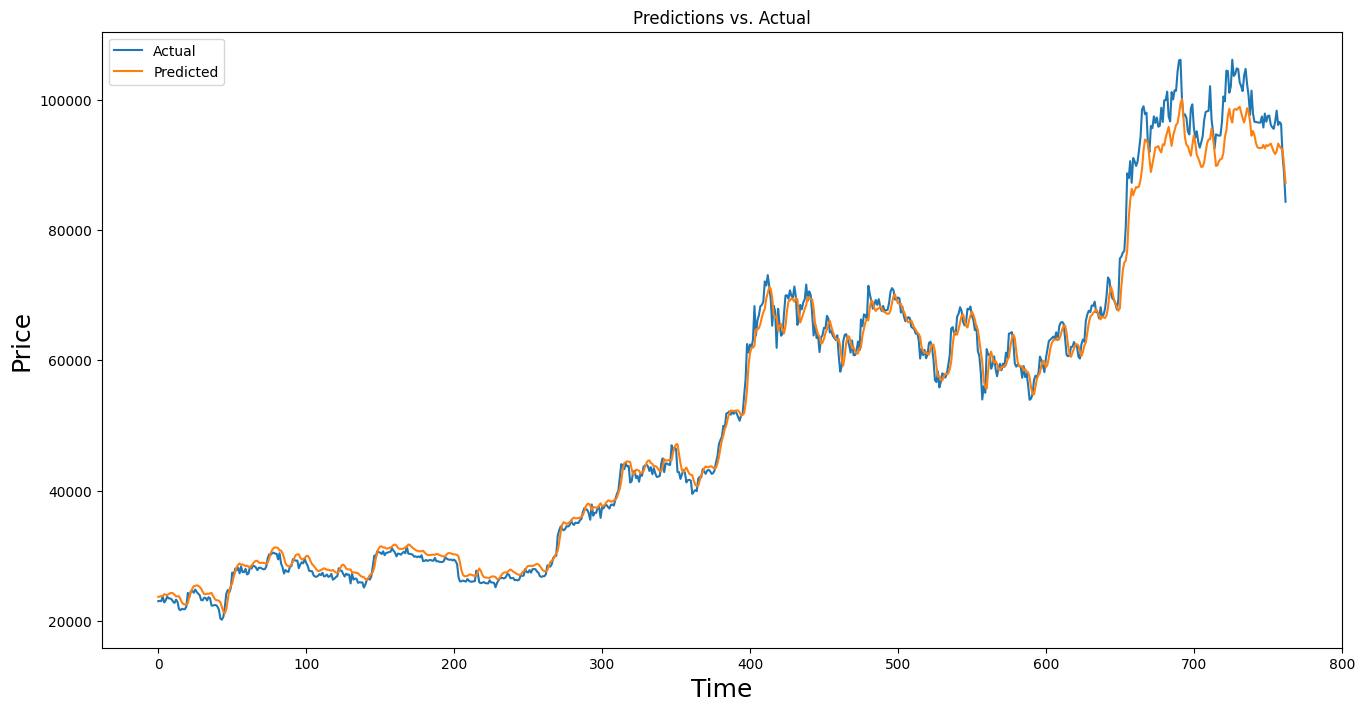

In [ ]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.title('Predictions vs. Actual')
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend()
plt.show()

# **Predict Tomorrow's Price**

In [ ]:
# Predict tomorrow's price
last_60_days = scaled_data[-60:,:]
last_60_days = np.reshape(last_60_days, (1, last_60_days.shape[0], 1))
tomorrow_prediction = model.predict(last_60_days)
tomorrow_prediction = scaler.inverse_transform(tomorrow_prediction)

print("Predicted price for tomorrow:", tomorrow_prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted price for tomorrow: 83971.94


# **30-Day Price Range Prediction**

**Predictions for the Next 30 Days**

In [ ]:
# Assuming your model is named 'model' and 'scaler' is your MinMaxScaler
# Get the last 60 days' data
last_60_days = scaled_data[-60:, :]

# Create an empty list to store the 30-day predictions
future_predictions = []

# Predict for the next 30 days, iteratively
for _ in range(30):
    # Reshape the input data for the model
    input_data = last_60_days[-60:].reshape(1, 60, 1)

    # Make a prediction for the next day
    prediction = model.predict(input_data)

    # Inverse transform the prediction to get the actual price
    prediction = scaler.inverse_transform(prediction)[0][0]

    # Append the prediction to the list
    future_predictions.append(prediction)

    # Update the input data for the next prediction
    last_60_days = np.append(last_60_days, prediction.reshape(-1, 1), axis=0)
    last_60_days = last_60_days[-60:] # Keep only the last 60 days

# Convert predictions to a NumPy array
future_predictions = np.array(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

**Calculate the Range**

In [ ]:
# Calculate the minimum and maximum predicted values for the next 30 days
min_price = future_predictions.min()
max_price = future_predictions.max()

print(f"Predicted price range for the next 30 days: ${min_price:.2f} - ${max_price:.2f}")

Predicted price range for the next 30 days: $83971.94 - $264146.62


**Visualize the Predictions**

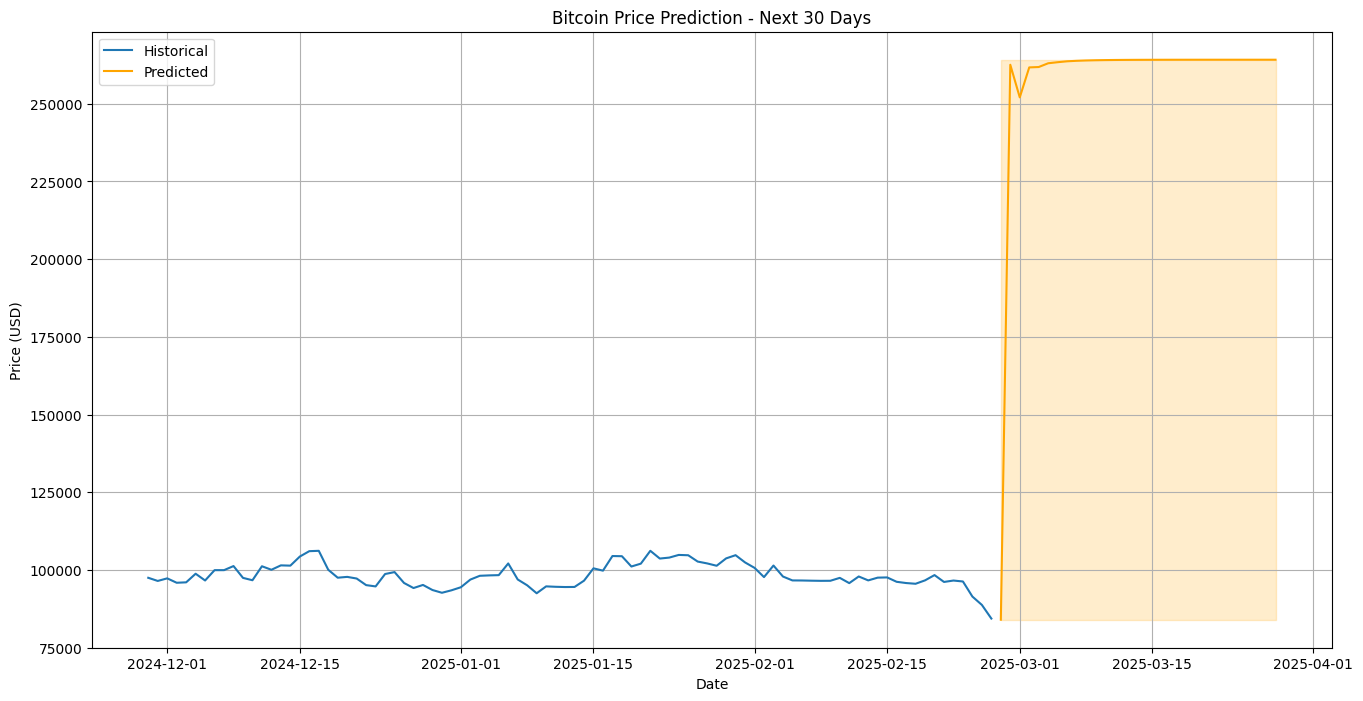

In [ ]:
# Create a date range for the next 30 days
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30, freq='D')

# Plot the historical data and the predicted range
plt.figure(figsize=(16, 8))
plt.plot(df.index[-90:], df['Close'][-90:], label='Historical') # Plot last 90 days of historical data
plt.plot(future_dates, future_predictions, label='Predicted', color='orange')
plt.fill_between(future_dates, min_price, max_price, alpha=0.2, color='orange')  # Fill the range
plt.title('Bitcoin Price Prediction - Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()